## Dyslexia detection using eeg brain wave signals
[Kaggle Data set](https://www.kaggle.com/datasets/wanghaohan/confused-eeg)

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import timeit

### taking data N dimensional samples

In [60]:
df = pd.read_csv('../EEG_data.csv')
data=pd.read_csv('../demographic_info.csv')

renaming the features for easy to use (like in original dataset have some unnecessary space) and joining the dataset 

In [61]:
data = data.rename(columns = {'subject ID': 'SubjectID',' gender':'gender',' age':'age',' ethnicity':'ethnicity'})
df = df.merge(data,how = 'inner',on = 'SubjectID')

In [62]:
df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,ethnicity,gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,Han Chinese,M
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,Han Chinese,M
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,Han Chinese,M
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,Han Chinese,M
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,Han Chinese,M


replacing string values with integer values and dropping the meaningless features

In [63]:
df['gender']=df['gender'].replace({'M':1,'F':0})
df['ethnicity']=df['ethnicity'].replace({'Han Chinese':0,'Bengali':1,'English':2})
df.drop(columns = ['SubjectID','VideoID','predefinedlabel'],inplace=True)

/tmp/ipykernel_1238/2564822645.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender']=df['gender'].replace({'M':1,'F':0})
/tmp/ipykernel_1238/2564822645.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ethnicity']=df['ethnicity'].replace({'Han Chinese':0,'Bengali':1,'English':2})


defining the target

In [64]:
target=df['user-definedlabeln']

<Axes: title={'center': 'Correlation with Target'}>

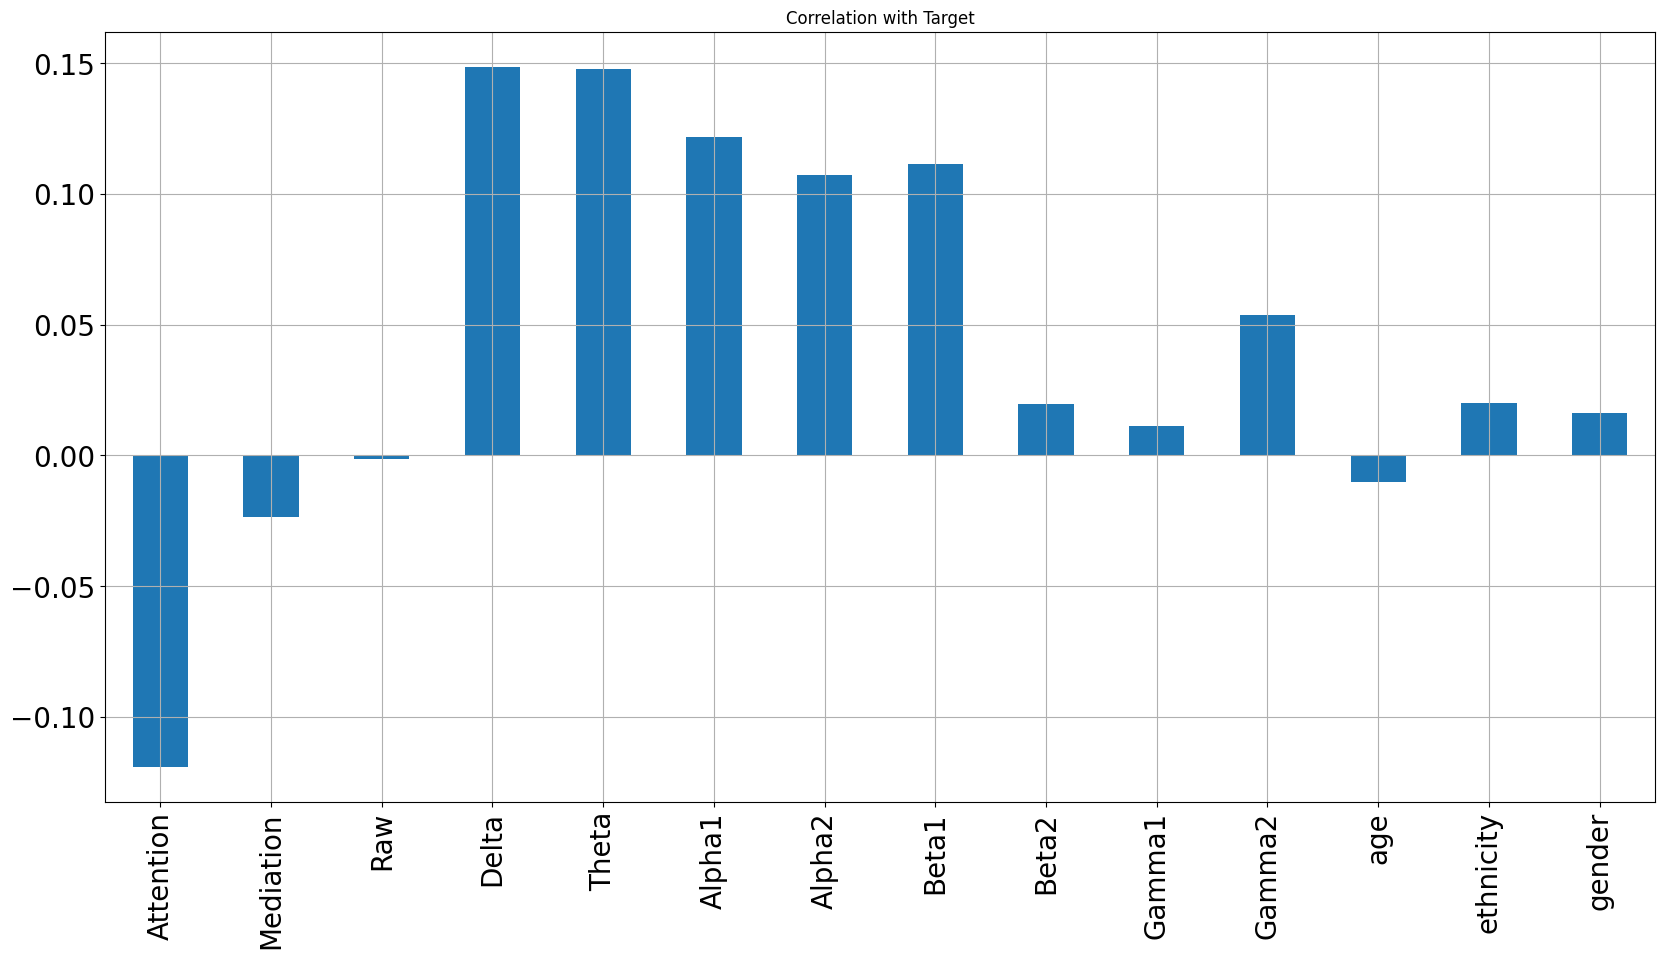

In [65]:
X=df.drop(['user-definedlabeln'],axis=1)
X.corrwith(df['user-definedlabeln']).plot.bar(
        figsize = (20, 10), title = "Correlation with Target", fontsize = 20,
        rot = 90, grid = True)

Referred from : https://www.geeksforgeeks.org/principal-component-analysis-pca/

### Dimensionality reduction using PCA

In [66]:
# Mean
X_mean = X.mean()

# Standard deviation
X_std = X.std()

# Standardization
Z = (X - X_mean) / X_std


In [67]:
Z.shape

(12811, 14)

The covariance matrix helps us visualize how strong the dependency of two features is with each other in the feature space.

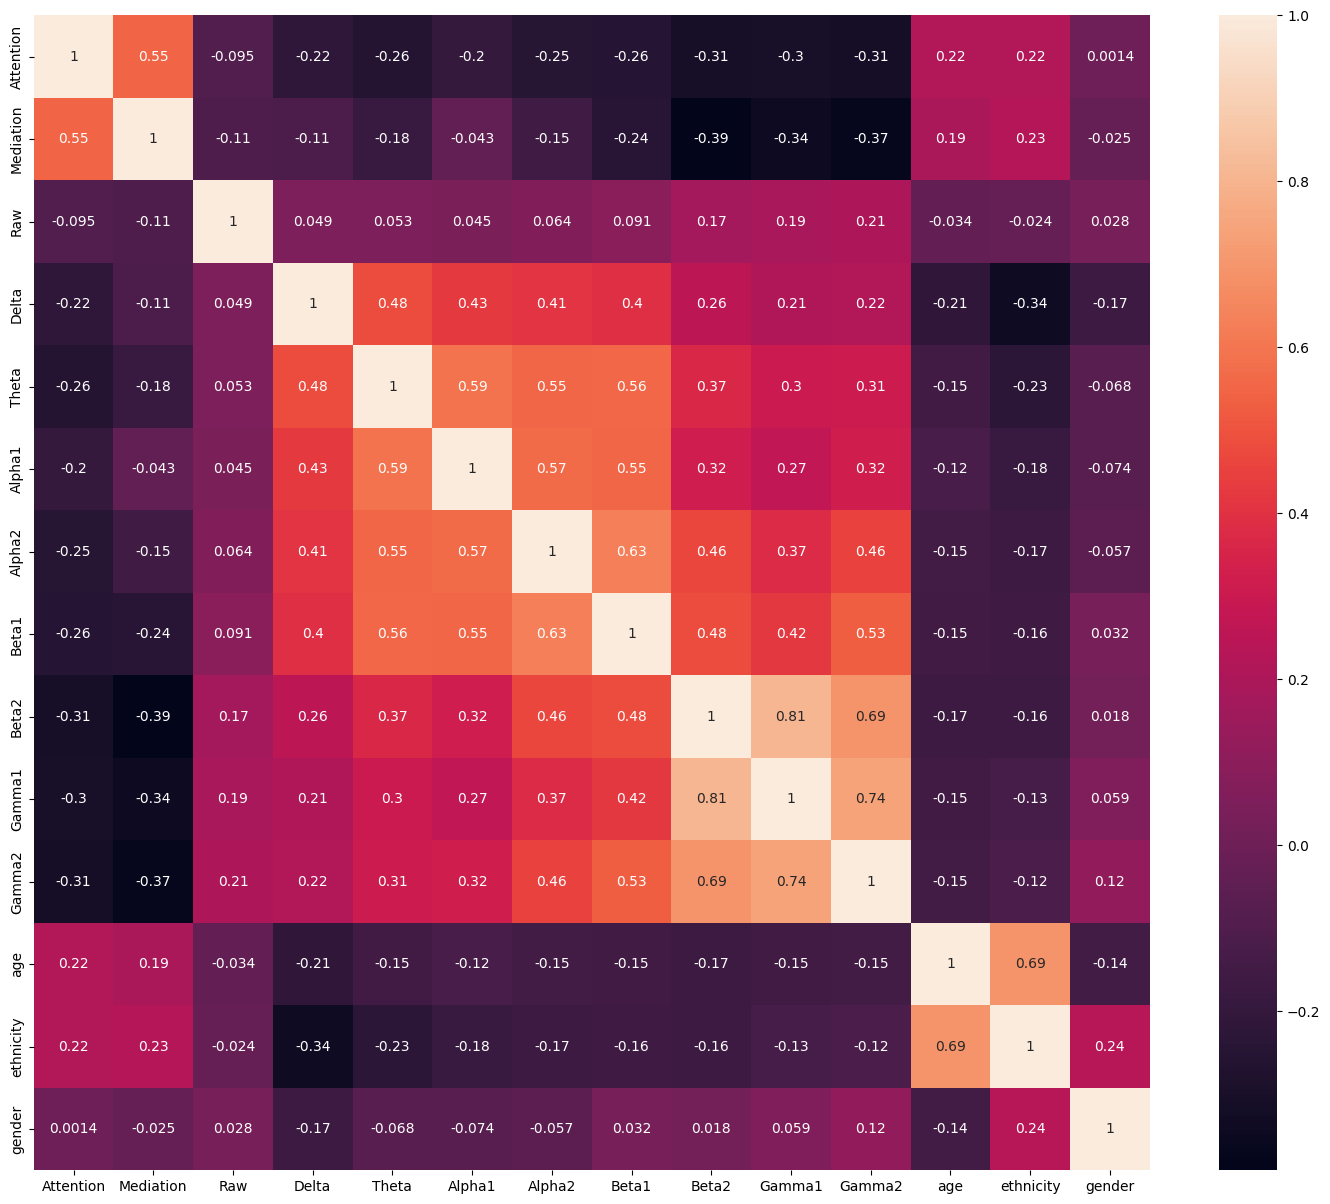

In [68]:
c = Z.cov()
 
# Plot the covariance matrix
plt.figure(figsize=(18,15))
sns.heatmap(c,annot=True)
plt.show()

Now we will compute the `eigenvectors` and `eigenvalues` for our feature space which serve a great purpose in identifying the principal components for our feature space.

In [69]:
eigenvalues, eigenvectors = np.linalg.eig(c)
print('Eigen values:\n', eigenvalues)
print('Eigen values Shape:', eigenvalues.shape)
print('Eigen Vector Shape:', eigenvectors.shape)

Eigen values:
 [4.7682621  1.74196905 1.62883445 1.07333627 0.98162116 0.8992218
 0.16852763 0.20789281 0.28328842 0.34628998 0.39166226 0.47508206
 0.4552567  0.57875531]
Eigen values Shape: (14,)
Eigen Vector Shape: (14, 14)


In [70]:
# Index the eigenvalues in descending order 
idx = eigenvalues.argsort()[::-1]

# Sort the eigenvalues in descending order 
eigenvalues = eigenvalues[idx]

# sort the corresponding eigenvectors accordingly
eigenvectors = eigenvectors[:,idx]


In [71]:
eigenvalues

array([4.7682621 , 1.74196905, 1.62883445, 1.07333627, 0.98162116,
       0.8992218 , 0.57875531, 0.47508206, 0.4552567 , 0.39166226,
       0.34628998, 0.28328842, 0.20789281, 0.16852763])

In [72]:
explained_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)
explained_var

array([0.34059015, 0.46501651, 0.58136183, 0.65802871, 0.7281445 ,
       0.79237463, 0.8337143 , 0.86764873, 0.90016706, 0.92814294,
       0.95287794, 0.97311283, 0.98796231, 1.        ])

#### Determine the Number of Principal Components 
Here we can either consider the number of principal components of any value of our choice or by limiting the explained variance. Here I am considering explained variance more than equal to 50%. Let’s check how many principal components come into this.

In [73]:
n_components = np.argmax(explained_var >= 0.5) + 1
n_components

np.int64(3)

##### Project the Data onto the Selected Principal Components

- Find the projection matrix, It is a matrix of eigenvectors corresponding to the largest eigenvalues of the covariance matrix of the data. it projects the high-dimensional dataset onto a lower-dimensional subspace.
- The eigenvectors of the covariance matrix of the data are referred to as the principal axes of the data, and the projection of the data instances onto these principal axes are called the principal components. 

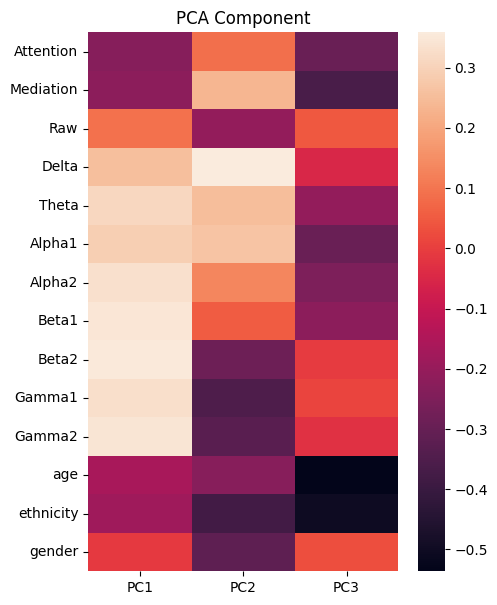

In [79]:
# PCA component or unit matrix
n_components = 3
u = eigenvectors[:,:n_components]
pca_component = pd.DataFrame(u,
							index = X.columns,
							columns=['PC{}'.
							format(i+1)
							for i in range(n_components)]
							)

# plotting heatmap
plt.figure(figsize =(5, 7))
sns.heatmap(pca_component)
plt.title('PCA Component')
plt.show()
# print(pca_component)

### PCA using Using Sklearn

In [17]:
# Let's say, components = 5
pca = PCA(n_components=3)

x_pca = pca.fit_transform(Z)

# Create the dataframe
df_pca1 = pd.DataFrame(x_pca,
					columns=['PC{}'.
					format(i+1)
						for i in range(n_components)])
print(df_pca1)

            PC1       PC2       PC3
0     -0.249166  0.279097 -0.391905
1     -1.066146  0.381432 -1.138734
2      1.936326 -0.500623  0.778215
3      0.711335 -0.621825 -0.079765
4      1.387595 -0.284455  0.328943
...         ...       ...       ...
12806 -0.986210 -0.590496 -0.884353
12807  4.368055 -0.279699  1.123891
12808 -0.162823 -1.227479 -0.611370
12809 -0.904352 -0.741969 -1.063394
12810  3.787145 -1.127547  0.754305

[12811 rows x 3 columns]


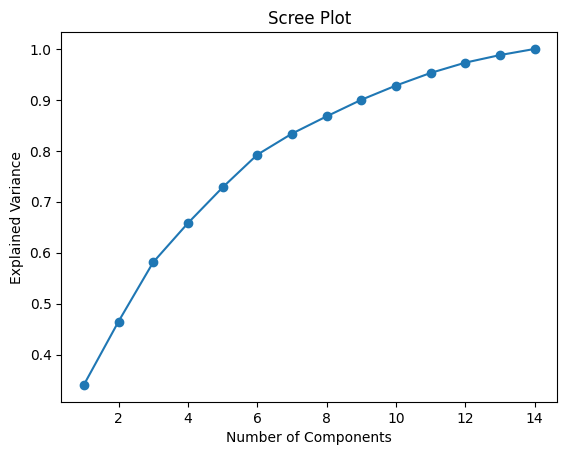

In [18]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Scree Plot')
plt.show()

In [19]:
scaler = StandardScaler()
X=scaler.fit_transform(df_pca1)

### Division the dataset into training and testing set

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
y=df['user-definedlabeln']
X_train,x_test,Y_train,y_test=train_test_split(X,y,random_state=108,test_size=0.27)

### ML algorithm SVM

In [22]:
from sklearn.svm import SVC

In [23]:
svm_classifier = SVC(random_state=108)

# Train the classifier on the training data
svm_classifier.fit(X_train, Y_train)

KeyboardInterrupt: 

### Trained classification model `svm_classifier`

In [ ]:
predictions = svm_classifier.predict(x_test).astype(int)
predictions

array([0, 0, 1, ..., 0, 0, 0])

### accuracy of the model

In [ ]:
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,precision_score,recall_score,f1_score

In [ ]:
accuracy = accuracy_score(y_test, predictions)
accuracy

0.6299508528476438

### performance evaluation of the model

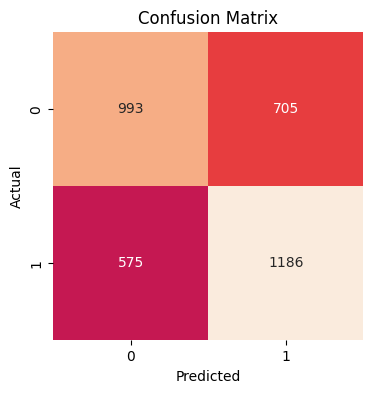

In [ ]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 4))

sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

TP = True Positive<br>
TN = True Negative<br>
FP = False Positive<br>
FN = False Negative<br>

$ Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

$ Precision = \frac{TP}{TP + FP} $<br>

$ Recall = \frac{TP}{TP + FN} $ <br>

$ F1 score = \frac{2×Precision×Recall}{Precision+Recall} $

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.63      0.58      0.61      1698
         1.0       0.63      0.67      0.65      1761

    accuracy                           0.63      3459
   macro avg       0.63      0.63      0.63      3459
weighted avg       0.63      0.63      0.63      3459



All dimensions pca svm

In [ ]:
# for i in range(1,15):
# 	k=i
# 	pca = PCA(n_components=k)

# 	x_pca = pca.fit_transform(Z)

# 	# Create the dataframe
# 	df_pca1 = pd.DataFrame(x_pca,
# 						columns=['PC{}'.
# 						format(i+1)
# 							for i in range(k)])

# 	scaler = StandardScaler()
# 	X=scaler.fit_transform(df_pca1)

# 	y=df['user-definedlabeln']
# 	X_train,x_test,Y_train,y_test=train_test_split(X,y,random_state=108,test_size=0.27)
# 	start = timeit.default_timer()
# 	svm_classifier = SVC()

# 	# Train the classifier on the training data
# 	svm_classifier.fit(X_train, Y_train)

# 	predictions = svm_classifier.predict(x_test).astype(int)

# 	accuracy = accuracy_score(y_test, predictions)

# 	stop = timeit.default_timer()

# 	print("for k = ", k, "Accuracy is: ", accuracy, "Time taken: ", stop-start)

### using keras

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks,layers

E0000 00:00:1730742566.291922   60870 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730742566.297082   60870 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Two hidden layers with 256 neurons each are added to the model. The activation function used is Rectified Linear Unit (ReLU), which is commonly used in hidden layers of neural networks.

In [ ]:
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(3,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

tb_callback = keras.callbacks.TensorBoard(log_dir="logs/", histogram_freq=1)

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy',keras.metrics.AUC(name='auc')]
             )
# The model is trained using the training data (X_train, Y_train) with a validation split of 20%, a batch size of 32, and training for 50 epochs. Additionally, a callback is used to reduce the learning rate on plateau during training.
batch_size=32
epochs=50
history=model.fit(
            X_train,
            Y_train,
            validation_split=0.2,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[callbacks.ReduceLROnPlateau(),tb_callback]
)

Epoch 1/50


/home/animesh/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


223/234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5746 - auc: 0.5908 - loss: 0.6818

KeyboardInterrupt: 

In [ ]:
model.evaluate(x_test,y_test)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6280 - auc: 0.6795 - loss: 0.6400


[0.6388580799102783, 0.635732889175415, 0.6855908036231995]

In [ ]:
y_true = np.array(y_test)

y_pred = np.squeeze(model.predict(x_test))
y_pred = np.array(y_pred >=0.5, dtype=np.int64)
y_pred

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
accuracyKeras=accuracy_score(y_true, y_pred)
accuracyKeras

0.6357328707718994

In [ ]:
print("Precision:", precision_score(y_test, 
                                    y_pred, 
                                    average="weighted"))
  
print('Recall:', recall_score(y_test, 
                              y_pred, 
                              average="weighted"))

print('F1 score:', f1_score(y_test, y_pred, 
                            average="weighted"))

Precision: 0.6356559161344697
Recall: 0.6357328707718994
F1 score: 0.6355506070014614


In [ ]:
for i in range(1,15):
	k=i
	pca = PCA(n_components=k)

	x_pca = pca.fit_transform(Z)

	# Create the dataframe
	df_pca1 = pd.DataFrame(x_pca,
						columns=['PC{}'.
						format(i+1)
							for i in range(k)])

	scaler = StandardScaler()
	X=scaler.fit_transform(df_pca1)

	y=df['user-definedlabeln']
	X_train,x_test,Y_train,y_test=train_test_split(X,y,random_state=108,test_size=0.27)
	
	inputs = tf.keras.Input(shape=(X_train.shape[1],))
	x = layers.Dense(256, activation='relu')(inputs)
	x = layers.Dense(256, activation='relu')(x)
	outputs = layers.Dense(1, activation='sigmoid')(x)

	model=keras.Model(inputs,outputs)
	model.compile(optimizer='adam',
				loss='binary_crossentropy',
				metrics=['accuracy',keras.metrics.AUC(name='auc')]
				)
	batch_size=32
	epochs=50
	history=model.fit(
				X_train,
				Y_train,
				validation_split=0.2,
				batch_size=batch_size,
				epochs=epochs,
				verbose=0,
				callbacks=[callbacks.ReduceLROnPlateau()]
	)
	start = timeit.default_timer()
	model.evaluate(x_test,y_test)

	y_true = np.array(y_test)
	y_pred = np.squeeze(model.predict(x_test))
	y_pred = np.array(y_pred >=0.5, dtype=np.int64)

	accuracyKeras=accuracy_score(y_true, y_pred)
	stop = timeit.default_timer()

	print("for k = ",k,"accuracy keras is: ",accuracyKeras,"time taken is: ",stop-start)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5765 - auc: 0.5850 - loss: 0.6809
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
for k =  1 accuracy keras is:  0.5900549291702805 time taken is:  0.6353027879995352
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5952 - auc: 0.6405 - loss: 0.6582
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
for k =  2 accuracy keras is:  0.5981497542642382 time taken is:  0.5903989529997489
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6309 - auc: 0.6795 - loss: 0.6397
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
for k =  3 accuracy keras is:  0.6351546689794738 time taken is:  0.7808398779998242
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6578 - auc: 0.7095 - loss: 0.6192
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
for k =  4 accuracy keras is:  0.6608846487424112 time taken is:  0.6436961429990333
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6438 - auc: 0.7106 - loss: 0.6170
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
for k =  5